# Configuración de la GPU

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Preparación de los Directorios

In [2]:
import os

ferDirectory = os.path.join(os.getcwd(), 'FER-2013')
trainDirectory = os.path.join(ferDirectory, 'train')
testDirectory = os.path.join(ferDirectory, 'test')

print(f"FER directory:          {ferDirectory}")
print(f"FER train directory:    {trainDirectory}")
print(f"FER test directory:     {testDirectory}")

FER directory:          C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\EmotionGame\FER-2013
FER train directory:    C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\EmotionGame\FER-2013\train
FER test directory:     C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\EmotionGame\FER-2013\test


# Modelos sin Augmentación de Datos

In [3]:
trainData = tf.keras.preprocessing.image_dataset_from_directory(trainDirectory,
                                                                image_size=(48, 48),
                                                                batch_size=32,
                                                                seed=200,
                                                                validation_split=.2,
                                                                label_mode='categorical',
                                                                subset="training",
                                                                color_mode="grayscale")

validData = tf.keras.preprocessing.image_dataset_from_directory(trainDirectory,
                                                                image_size=(48, 48),
                                                                batch_size=32,
                                                                seed=200,
                                                                validation_split=.2,
                                                                label_mode='categorical',
                                                                subset="validation",
                                                                color_mode="grayscale")

testData = tf.keras.preprocessing.image_dataset_from_directory(testDirectory,
                                                              image_size=(48, 48),
                                                              batch_size=32,
                                                              label_mode='categorical',
                                                              color_mode="grayscale")

labelNames = trainData.class_names

normalization = tf.keras.layers.Rescaling(1./255)
trainData = trainData.map(lambda x, y: (normalization(x), y))
validData = validData.map(lambda x, y: (normalization(x), y))
testData = testData.map(lambda x, y: (normalization(x), y))

print(labelNames)

Found 28635 files belonging to 7 classes.
Using 22908 files for training.
Found 28635 files belonging to 7 classes.
Using 5727 files for validation.
Found 7164 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


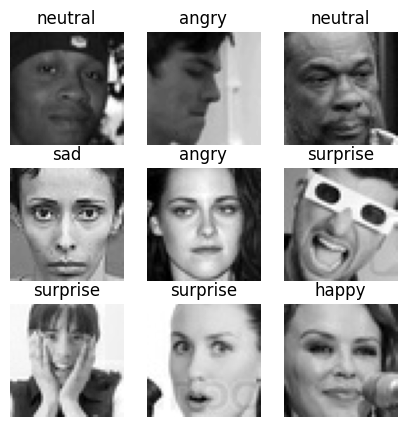

In [4]:
# Visualización de algunos datos del dataset
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in testData.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.title(labelNames[np.argmax(labels[i])])
    plt.imshow(images[i], cmap="gray")

In [5]:
#Creación de 2 versiones de modelos CNN para data con Augmentación
modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), strides=1, padding="same", activation='elu', input_shape=(48, 48, 1)),
  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.3),
    
  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.MaxPooling2D(2, 2),
    
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(256, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='elu'),
  tf.keras.layers.Dense(7, activation='softmax')
])

In [6]:
# Compilación de los nuevos modelos
modeloCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import TensorBoard

In [6]:
#Cargar la extension de tensorboard de colab
%load_ext tensorboard

In [ ]:
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
with tf.device('/gpu:0'):
    modeloCNN.fit(trainData,
                  validation_data=validData,
                  epochs=60,
                  callbacks=[tensorboardCNN])

# Modelos con Augmentación de Datos

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
batchSize = 64

trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=5,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=15,
                                  zoom_range=[1.0, 1.3],
                                  horizontal_flip=True,
                                  validation_split=0.2)

validDataGen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)

trainDataAug = trainDataGen.flow_from_directory(trainDirectory,
                                                target_size=(48,48),
                                                batch_size=batchSize,
                                                color_mode="grayscale",
                                                class_mode="categorical",
                                                shuffle=True,
                                                subset='training')

validDataAug = validDataGen.flow_from_directory(trainDirectory,
                                                target_size=(48,48),
                                                batch_size=batchSize,
                                                color_mode="grayscale",
                                                class_mode="categorical",
                                                shuffle=False,
                                                subset="validation")

Found 22910 images belonging to 7 classes.
Found 5725 images belonging to 7 classes.


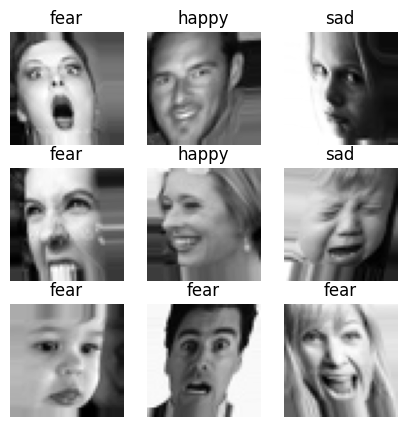

In [9]:
plt.figure(figsize=(5, 5))
images, labels = trainDataAug.__getitem__(1)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.title(labelNames[int(np.argmax(labels[i]))])
    plt.imshow(images[i], cmap="gray")

In [40]:
#Creación de 2 versiones de modelos CNN para data con Augmentación
modeloAugCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.Conv2D(64, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.DepthwiseConv2D((3, 3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
    
  tf.keras.layers.Conv2D(64, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.DepthwiseConv2D((3, 3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(128, (3,3), padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.DepthwiseConv2D((3, 3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
                                  
  tf.keras.layers.Conv2D(256, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.DepthwiseConv2D((3, 3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(7, activation='softmax')
])

In [41]:
# Compilación de los nuevos modelos
modeloAugCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [42]:
tensorboardAugCNN = TensorBoard(log_dir='logs/cnnAug')
with tf.device('/gpu:0'):
    modeloAugCNN.fit(trainDataAug,
                     validation_data=validDataAug,
                     epochs=100,
                     batch_size=64,
                     steps_per_epoch=int(np.ceil(trainDataAug.n / float(64))),
                     validation_steps=int(np.ceil(validDataAug.n / float(64))),
                     callbacks=[tensorboardAugCNN])

Epoch 1/100
358/358 [==============================] - 15s 38ms/step - loss: 1.8936 - accuracy: 0.3182 - val_loss: 1.9775 - val_accuracy: 0.2515
Epoch 2/100
358/358 [==============================] - 13s 36ms/step - loss: 1.5222 - accuracy: 0.4247 - val_loss: 1.4860 - val_accuracy: 0.4409
Epoch 3/100
358/358 [==============================] - 14s 38ms/step - loss: 1.3618 - accuracy: 0.4866 - val_loss: 1.3306 - val_accuracy: 0.4887
Epoch 4/100
358/358 [==============================] - 13s 37ms/step - loss: 1.2667 - accuracy: 0.5184 - val_loss: 1.3203 - val_accuracy: 0.5057
Epoch 5/100
358/358 [==============================] - 13s 37ms/step - loss: 1.2103 - accuracy: 0.5414 - val_loss: 1.3188 - val_accuracy: 0.5081
Epoch 6/100
358/358 [==============================] - 13s 36ms/step - loss: 1.1732 - accuracy: 0.5542 - val_loss: 1.2113 - val_accuracy: 0.5459
Epoch 7/100
358/358 [==============================] - 13s 37ms/step - loss: 1.1247 - accuracy: 0.5719 - val_loss: 1.2449 - val_ac

358/358 [==============================] - 13s 38ms/step - loss: 0.4805 - accuracy: 0.8216 - val_loss: 1.2900 - val_accuracy: 0.6267
Epoch 58/100
358/358 [==============================] - 13s 37ms/step - loss: 0.4628 - accuracy: 0.8273 - val_loss: 1.3993 - val_accuracy: 0.6327
Epoch 59/100
358/358 [==============================] - 14s 38ms/step - loss: 0.4669 - accuracy: 0.8270 - val_loss: 1.4360 - val_accuracy: 0.6285
Epoch 60/100
358/358 [==============================] - 13s 36ms/step - loss: 0.4522 - accuracy: 0.8328 - val_loss: 1.3399 - val_accuracy: 0.6369
Epoch 61/100
358/358 [==============================] - 14s 39ms/step - loss: 0.4517 - accuracy: 0.8326 - val_loss: 1.3431 - val_accuracy: 0.6362
Epoch 62/100
358/358 [==============================] - 13s 36ms/step - loss: 0.4389 - accuracy: 0.8374 - val_loss: 1.3742 - val_accuracy: 0.6356
Epoch 63/100
358/358 [==============================] - 13s 37ms/step - loss: 0.4386 - accuracy: 0.8386 - val_loss: 1.4164 - val_accuracy

In [45]:
modeloAugCNN.evaluate(testData)

224/224 [==============================] - 2s 8ms/step - loss: 1.6642 - accuracy: 0.6545


[1.6641881465911865, 0.6545225977897644]

# Usando MobileNet

In [155]:
batchSize = 32

trainDataMobGen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=15,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      shear_range=15,
                                      zoom_range=[0.8, 1.3],
                                      horizontal_flip=True,
                                      validation_split=0.2)

validDataMobGen = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.2)

trainDataMobAug = trainDataMobGen.flow_from_directory(trainDirectory,
                                                    target_size=(48,48),
                                                    batch_size=batchSize,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    subset='training')

validDataMobAug = validDataMobGen.flow_from_directory(trainDirectory,
                                                    target_size=(48,48),
                                                    batch_size=batchSize,
                                                    class_mode="categorical",
                                                    shuffle=False,
                                                    subset="validation")

Found 22910 images belonging to 7 classes.
Found 5725 images belonging to 7 classes.


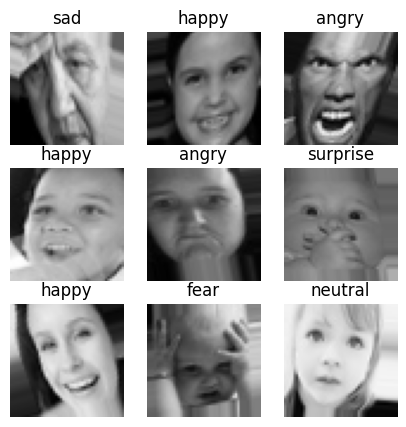

In [156]:
plt.figure(figsize=(5, 5))
images, labels = trainDataMobAug.__getitem__(1)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.title(labelNames[int(np.argmax(labels[i]))])
    plt.imshow(images[i], cmap="gray")

In [157]:
mobileBase = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(48,48,3),
                                                     include_top=False,
                                                     weights="imagenet")

for layer in mobileBase.layers[:-16]:
    layer.trainable = False

#Creación de un nuevo modelo que utiliza MobileNetV2 para data con Augmentación
modeloMobile = tf.keras.models.Sequential([
  mobileBase,
  tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
    
  tf.keras.layers.Conv2D(64, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(128, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
                                  
  tf.keras.layers.Conv2D(256, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
    
  tf.keras.layers.GlobalAveragePooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(7, activation='softmax')
])

In [158]:
# Compilación de los nuevos modelos
modeloMobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [159]:
tensorboardMobAug = TensorBoard(log_dir='logs/mobAug')
with tf.device('/gpu:0'):
    modeloMobile.fit(trainDataMobAug,
                     validation_data=validDataMobAug,
                     epochs=30,
                     batch_size=32,
                     steps_per_epoch=int(np.ceil(trainDataMobAug.n / float(32))),
                     validation_steps=int(np.ceil(validDataMobAug.n / float(32))),
                     callbacks=[tensorboardMobAug])

Epoch 1/30
716/716 [==============================] - 24s 30ms/step - loss: 2.0154 - accuracy: 0.2528 - val_loss: 4.1020 - val_accuracy: 0.1958
Epoch 2/30
716/716 [==============================] - 22s 31ms/step - loss: 1.8458 - accuracy: 0.2966 - val_loss: 2.9417 - val_accuracy: 0.2730
Epoch 3/30
716/716 [==============================] - 21s 29ms/step - loss: 1.7925 - accuracy: 0.3117 - val_loss: 3.6287 - val_accuracy: 0.2903
Epoch 4/30
716/716 [==============================] - 22s 30ms/step - loss: 1.7965 - accuracy: 0.3247 - val_loss: 2.3185 - val_accuracy: 0.2990
Epoch 5/30
716/716 [==============================] - 21s 29ms/step - loss: 1.7725 - accuracy: 0.3207 - val_loss: 2.8034 - val_accuracy: 0.2236
Epoch 6/30
716/716 [==============================] - 22s 31ms/step - loss: 1.7728 - accuracy: 0.3318 - val_loss: 1.7101 - val_accuracy: 0.3448
Epoch 7/30
716/716 [==============================] - 21s 30ms/step - loss: 1.7451 - accuracy: 0.3469 - val_loss: 1.8707 - val_accuracy:

# Visualización de Tensorboard

In [ ]:
#Ejecutar tensorboard e indicarle que lea la carpeta "logs"
%tensorboard --logdir logs

# Guardado y Ejecución de Modelo TFLite

In [ ]:
# Crear una carpeta en caso se necesite
!mkdir saved_models

In [199]:
# Guardar un modelo .h5
tf.keras.models.save_model(modeloAugCNN, 'saved_models/modeloAugCNN.h5')

In [200]:
# Cargar un modelo .h5
model = tf.keras.models.load_model('saved_models/modeloAugCNN.h5')

In [201]:
# Convertir el modelo .h5 cargado a un modelo .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('saved_models/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Richard\AppData\Local\Temp\tmpu0l_i9rn\assets


INFO:tensorflow:Assets written to: C:\Users\Richard\AppData\Local\Temp\tmpu0l_i9rn\assets


In [202]:
import numpy as np

# Cargar una imagen de prueba para el modelo TFLite
image = tf.keras.utils.load_img("test_images/neutral.jpg",
                                color_mode="grayscale")
imgArray = tf.keras.utils.img_to_array(image)
imgArray = np.array([imgArray])  # Convertirlo a np.array para predicción en el modelo
imgArray /= 255.                 # Normalizar los valores de la imagen entre 0 y 1

In [203]:
# Crear el interpretador del modelo y alocar los tensores
interpreter = tf.lite.Interpreter(model_path="saved_models/model.tflite")
interpreter.allocate_tensors()

# Obtener detalles del input y output del modelo
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preparar el tensor de entrada con la imagen, invokar el modelo y obtener el tensor de salida
interpreter.set_tensor(input_details[0]['index'], imgArray)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print(output)

[[5.0550002e-06 2.5133755e-13 6.0639456e-02 5.2596893e-06 9.3903571e-01
  3.0893122e-04 5.5903356e-06]]


(-0.5, 47.5, 47.5, -0.5)

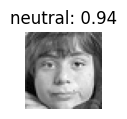

In [204]:
import matplotlib.pyplot as plt

imgArray = tf.keras.utils.img_to_array(image)
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
plt.title(f'{labelNames[np.argmax(output[0])]}: {output[0][np.argmax(output[0])]:.2f}')
plt.axis("off")